In [1]:
#@title Importations

import matplotlib.pyplot as plt
from collections import deque


In [2]:
#@title Exemple 9.1

class Graphe:
    
    # Graphe représenté par une matrice d'adjacence. On utilise un dictionnaire pour retrouver 
    # l'indice d'un sommet
    def __init__(self, dirige=False, value=False):
        self._sommets = {}
        self._matrice = []
        self._dirige = dirige
        self._value = value
        if self._value:
            self._valeur_defaut = None
        else:
            self._valeur_defaut = False

    def get_sommets(self) -> list:
        return list(self._sommets.keys())
    
    def est_adjacent(self, sommet_1, sommet_2) -> bool:
        indice_1 = self._sommets[sommet_1]
        indice_2 = self._sommets[sommet_2]
        return self._matrice[indice_1][indice_2] not in [None, False]
    
    def get_poids(self, sommet_1, sommet_2):
        indice_1 = self._sommets[sommet_1]
        indice_2 = self._sommets[sommet_2]
        if not self._value:
            raise ValueError("Pas de poids dans un graphe non valué")
        return self._matrice[indice_1][indice_2]


    # Pour Exercices 9.1 et 9.3      
    def ajouter_sommet(self, sommet):
        if sommet in self._sommets.keys():
            raise ValueError("Le sommet existe déjà")
        else:
            nouvel_indice = len(self._sommets)
            nouveau_tableau = [self._valeur_defaut] * (nouvel_indice + 1)
            self._sommets[sommet] = nouvel_indice
            for ligne in self._matrice:
                ligne.append(self._valeur_defaut)
            self._matrice.append(nouveau_tableau)

    # Pour Exercices 9.1 et 9.3
    def ajouter_arete(self, sommet_1, sommet_2, poids=None):
        if poids == None and self._value:
            raise ValueError("Il faut un poids dans un graphe valué")
        indice_1 = self._sommets[sommet_1]
        indice_2 = self._sommets[sommet_2]
        
        if self._value:
            valeur = poids
        else:
            valeur = True
        
        self._matrice[indice_1][indice_2] = valeur
        if not self._dirige:
            self._matrice[indice_2][indice_1] =  valeur

    # Pour exercices 9.4 et 9.5
    def get_voisins(self, sommet):
        voisins = []
        for candidat in self._sommets.keys():
            if self.est_adjacent(sommet, candidat):
                voisins.append(candidat)
        return voisins
    


In [4]:
#@title Fonction de dessin du graphe

# Gracieuseté de ChatGPT
def dessiner_graphe(graphe):
    import math
    import matplotlib.pyplot as plt
    from numbers import Number

    # --- Sommets ---
    sommets = sorted(graphe.get_sommets(), key=lambda s: graphe._sommets[s])
    n = len(sommets)

    if n == 0:
        print("Graphe vide")
        return

    # ---- Trouver sommet avec plus grand degré ----
    def deg(s):
        i = graphe._sommets[s]
        return sum(1 for v in graphe._matrice[i] if v not in [None, False])

    sommet_central = max(sommets, key=lambda s: deg(s))

    # Rotation pour que ce sommet soit en premier
    idx = sommets.index(sommet_central)
    sommets = sommets[idx:] + sommets[:idx]

    # --- Taille dynamique ---
    max_len = max(len(str(s)) for s in sommets)
    rayon_noeud = 0.35 + max_len * 0.12
    R = 3 + n * 0.6 + max_len * 0.3

    # Taille dynamique de l'image
    fig_size = max(7, 3 + n * 1.2)
    fig, ax = plt.subplots(figsize=(fig_size, fig_size))
    ax.set_aspect("equal")
    ax.axis("off")

    # --- Position circulaire (sommet le plus connecté en haut) ---
    positions = {}
    angle_step = 2 * math.pi / n
    for i, s in enumerate(sommets):
        angle = i * angle_step + math.pi / 2  # +90°, sommet en haut
        positions[s] = (R * math.cos(angle), R * math.sin(angle))

    # --- Arêtes ---
    for s1 in sommets:
        i1 = graphe._sommets[s1]
        x1, y1 = positions[s1]

        for s2 in sommets:
            i2 = graphe._sommets[s2]
            valeur = graphe._matrice[i1][i2]

            if valeur in [None, False]:
                continue

            if s1 == s2:
                continue

            if not graphe._dirige and i2 < i1:
                continue

            x2, y2 = positions[s2]
            dx = x2 - x1
            dy = y2 - y1
            dist = math.sqrt(dx*dx + dy*dy)
            if dist == 0:
                continue

            ux = dx / dist
            uy = dy / dist

            start_x = x1 + ux * rayon_noeud
            start_y = y1 + uy * rayon_noeud
            end_x   = x2 - ux * rayon_noeud
            end_y   = y2 - uy * rayon_noeud

            # Ligne principale
            ax.plot([start_x, end_x], [start_y, end_y], color="black", linewidth=1)

            # Flèche principale
            if graphe._dirige:
                ax.annotate("", xy=(end_x, end_y), xytext=(start_x, start_y),
                            arrowprops=dict(arrowstyle="->", lw=1, color="black"))

            # --- Poids : placé près de la flèche, à l'extérieur du sommet ---
            if graphe._value and isinstance(valeur, Number):
                # Décalage vers la fin de l'arête
                t = 0.85  # fraction de l'arête vers la flèche
                wx = start_x + t * (end_x - start_x)
                wy = start_y + t * (end_y - start_y)

                # Décalage perpendiculaire pour éviter de chevaucher l'arête
                offset = 0.2
                ox = -uy * offset
                oy =  ux * offset

                ax.text(wx + ox, wy + oy, str(valeur), fontsize=11,
                        ha="center", va="center", color="black")

    # --- Sommets ---
    for s in sommets:
        x, y = positions[s]
        i = graphe._sommets[s]

        has_loop = graphe._matrice[i][i] not in [None, False]

        circle = plt.Circle((x, y), rayon_noeud, edgecolor="black",
                            facecolor="white", linewidth=1.5)
        ax.add_patch(circle)

        ax.text(x, y, str(s), fontsize=12, ha="center", va="center",
                fontweight=('bold' if has_loop else 'normal'))

        # Poids de la boucle
        if has_loop and graphe._value and isinstance(graphe._matrice[i][i], Number):
            ax.text(x, y - rayon_noeud * 0.55,
                    f"({graphe._matrice[i][i]})",
                    fontsize=10, ha="center", va="center")

    plt.show()


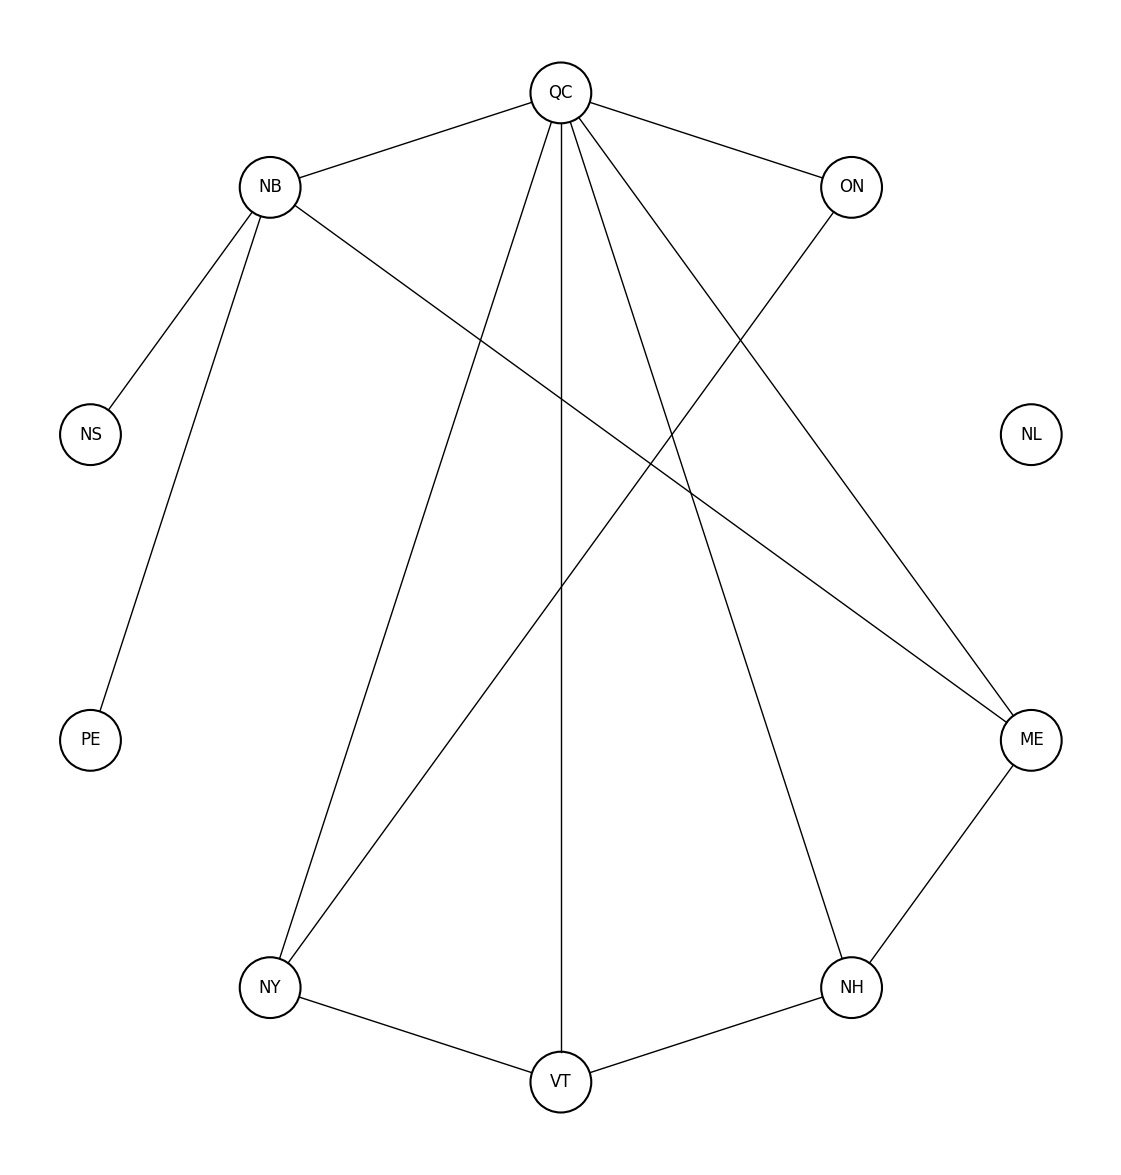

In [58]:
#title Exercice 9.2

graphe = Graphe()

provinces_etats = ["ON", "QC", "NB", "NS", "PE", "NY", "VT", "NH", "ME", "NL"]

for province in provinces_etats:
    graphe.ajouter_sommet(province)

graphe.ajouter_arete("ON", "QC")
graphe.ajouter_arete("ON", "NY")
graphe.ajouter_arete("QC", "NY")
graphe.ajouter_arete("QC", "VT")
graphe.ajouter_arete("QC", "NH")
graphe.ajouter_arete("QC", "ME")
graphe.ajouter_arete("QC", "NB")
graphe.ajouter_arete("NY", "VT")
graphe.ajouter_arete("VT", "NH")
graphe.ajouter_arete("NH", "ME")
graphe.ajouter_arete("ME", "NB")
graphe.ajouter_arete("NB", "NS")
graphe.ajouter_arete("NB", "PE")


dessiner_graphe(graphe)

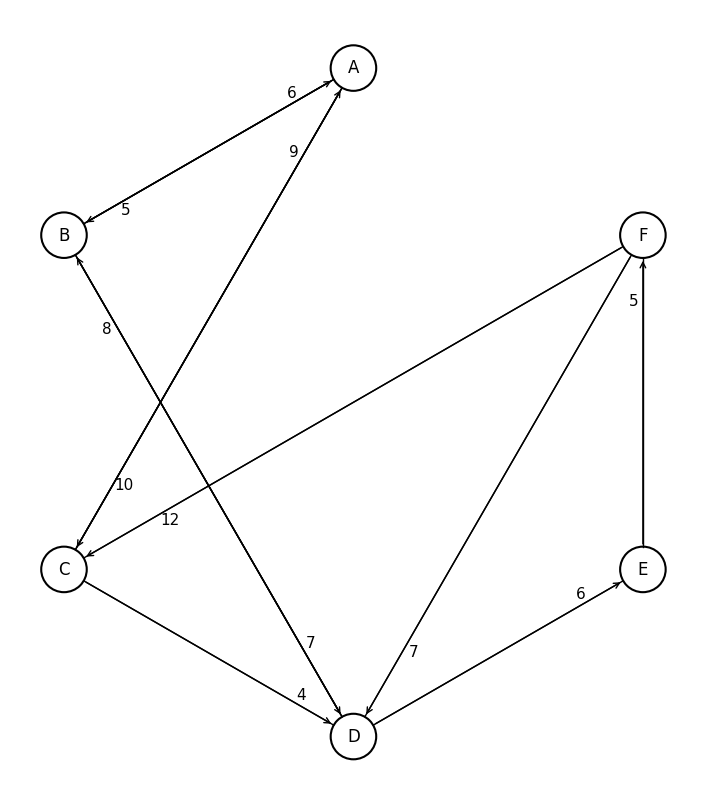

In [59]:
#title Exercice 9.3

graphe = Graphe(dirige=True, value=True)

stations = ["A", "B", "C", "D", "E", "F"]

for s in stations:
    graphe.ajouter_sommet(s)

graphe.ajouter_arete("A", "B", 5)
graphe.ajouter_arete("B", "A", 6)
graphe.ajouter_arete("A", "C", 10)
graphe.ajouter_arete("C", "A", 9)
graphe.ajouter_arete("B", "D", 7)
graphe.ajouter_arete("D", "B", 8)
graphe.ajouter_arete("C", "D", 4)
graphe.ajouter_arete("D", "E", 6)
graphe.ajouter_arete("E", "F", 5)
graphe.ajouter_arete("F", "C", 12)
graphe.ajouter_arete("F", "D", 7)

dessiner_graphe(graphe)

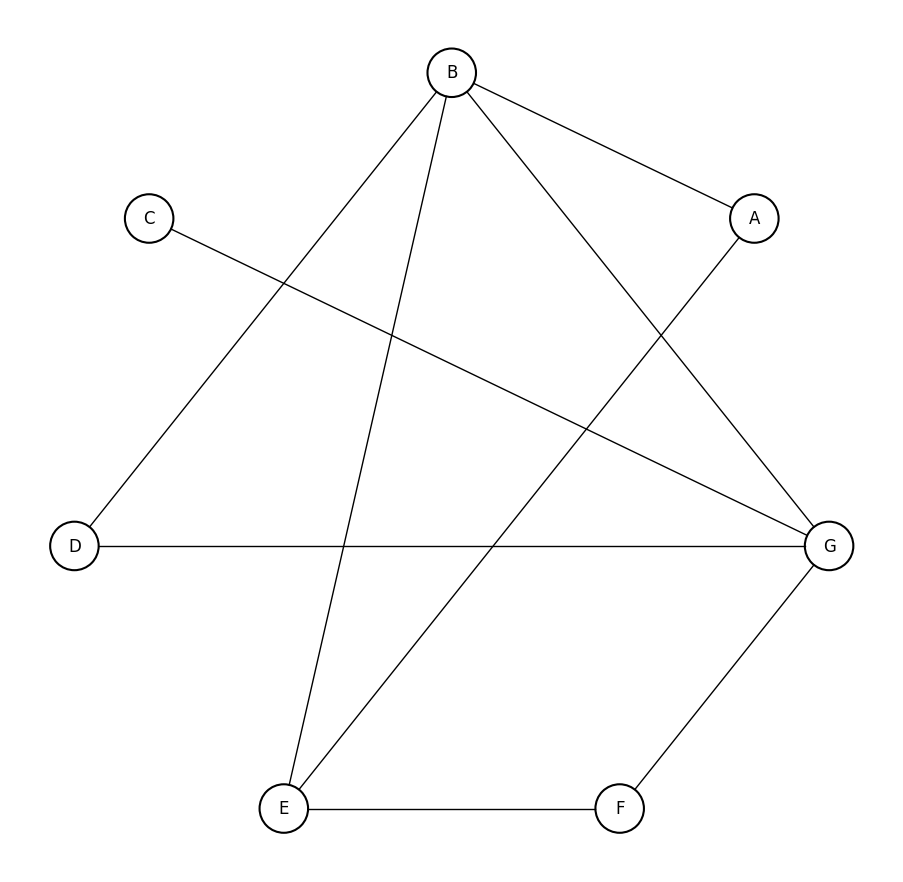

Parcours en largeur   : A B E D G F C
Parcours en profondeur: A B D G C F E


In [6]:
#@title Exercice 9.4

def parcours_largeur(graphe:Graphe, depart) -> list:
    marque = set()
    file_attente  = deque()
    file_attente.append(depart)
    marque.add(depart)
    parcours = []
    while len(file_attente) > 0:
        sommet = file_attente.popleft()
        parcours.append(sommet)
        for voisin in graphe.get_voisins(sommet):
            if voisin not in marque:
                file_attente.append(voisin)
                marque.add(voisin)
    return parcours

def parcours_profondeur(graphe:Graphe, depart) -> list:
    marque = set()
    parcours = []

    def _parcours_recursif(sommet):
        if sommet not in marque:
            marque.add(sommet)
            parcours.append(sommet)
            for voisin in graphe.get_voisins(sommet):
                _parcours_recursif(voisin)

    _parcours_recursif(depart)
    return parcours

graphe_non_oriente = Graphe()
sommets  = ["A", "B", "C", "D", "E", "F", "G"]
for sommet in sommets:
    graphe_non_oriente.ajouter_sommet(sommet)

graphe_non_oriente.ajouter_arete("A", "B")
graphe_non_oriente.ajouter_arete("A", "E")
graphe_non_oriente.ajouter_arete("B", "D")
graphe_non_oriente.ajouter_arete("B", "E")
graphe_non_oriente.ajouter_arete("B", "G")
graphe_non_oriente.ajouter_arete("C", "G")
graphe_non_oriente.ajouter_arete("D", "G")
graphe_non_oriente.ajouter_arete("E", "F")
graphe_non_oriente.ajouter_arete("F", "G")

dessiner_graphe(graphe_non_oriente)

sommet_depart = input("Entrez le sommet de départ: ")
sommets_largeur = parcours_largeur(graphe_non_oriente, sommet_depart)
sommets_profondeur = parcours_profondeur(graphe_non_oriente, sommet_depart)
print("Parcours en largeur   : " + " ".join(sommets_largeur))
print("Parcours en profondeur: " + " ".join(sommets_profondeur))

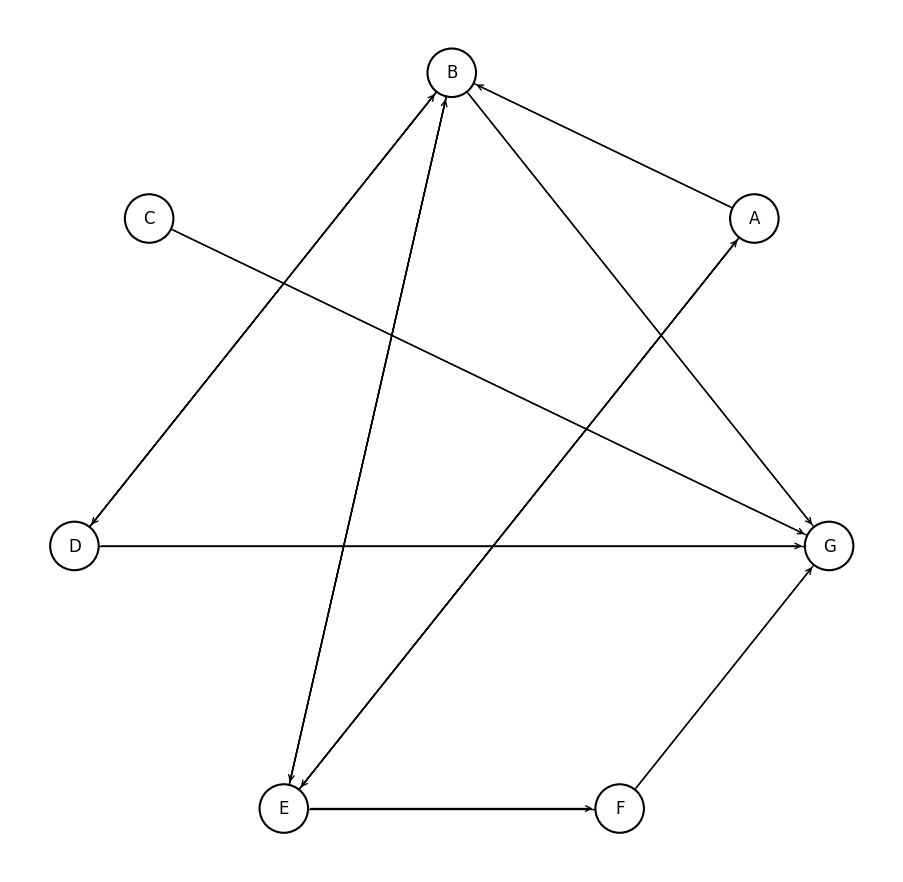

Parcours en largeur   : E A B F D G
Parcours en profondeur: E A B D G F


In [10]:
#@title Exercice 9.5

graphe_oriente = Graphe(dirige=True)
sommets  = ["A", "B", "C", "D", "E", "F", "G"]
for sommet in sommets:
    graphe_oriente.ajouter_sommet(sommet)

graphe_oriente.ajouter_arete("A", "B")
graphe_oriente.ajouter_arete("A", "E")
graphe_oriente.ajouter_arete("E", "A")
graphe_oriente.ajouter_arete("B", "D")
graphe_oriente.ajouter_arete("D", "B")
graphe_oriente.ajouter_arete("B", "E")
graphe_oriente.ajouter_arete("E", "B")
graphe_oriente.ajouter_arete("B", "G")
graphe_oriente.ajouter_arete("C", "G")
graphe_oriente.ajouter_arete("D", "G")
graphe_oriente.ajouter_arete("E", "F")
graphe_oriente.ajouter_arete("F", "G")

dessiner_graphe(graphe_oriente)

sommet_depart = input("Entrez le sommet de départ: ")
sommets_largeur = parcours_largeur(graphe_oriente, sommet_depart)
sommets_profondeur = parcours_profondeur(graphe_oriente, sommet_depart)
print("Parcours en largeur   : " + " ".join(sommets_largeur))
print("Parcours en profondeur: " + " ".join(sommets_profondeur))